# Simplex Algorithm

In [32]:
import math
import numpy as np
import pandas as pd

pd.set_option("display.precision", 3)
pd.set_option("display.width", 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Enter Variables
To prepare data for either of the 2 question provided in the following cells, convert them to code cell by pressing 'y' on keyboard (if the cell is in markdown state)

To enter your own system of equations, enter them as following:
1. c contains coefficients of the objective function, in the order:
    x1, x2, x3,... xi, s1, s2, s3,... sj, -M*A1, -M*A2,..., -M*An
2. mat contains the coefficients for the variable present in the constraint equations:
    Each row contains the coefficients of one equation, in the same order as mentioned above, with the addition of one extra number, which will contain the right hand side number of the constraint equation, i.e. the b-values.

## Question 20

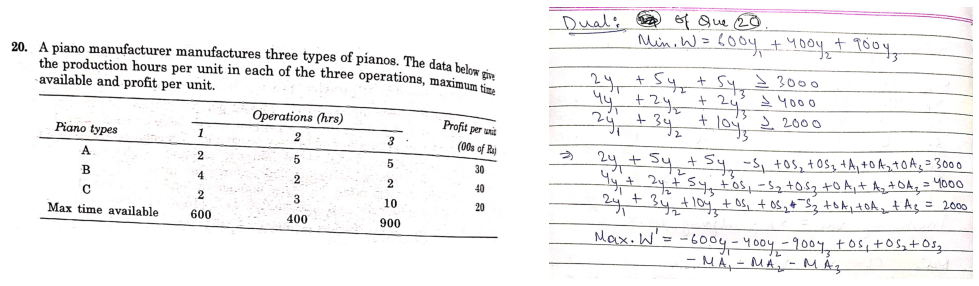

In [39]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
que = mpimg.imread(r'images\que20.png')
eqn = mpimg.imread(r'images\eqn20.png')
ax[0].imshow(que)
ax[1].imshow(eqn)
_= ax[0].axis(False)
_= ax[1].axis(False)
fig.subplots_adjust(wspace=0, hspace=0)

####  QUESTION 20 

#coefficients of z
c  = np.array([-600,-400,-900,0,0,0,-M,-M,-M])

#coefficients of constraints
mat = np.array([[2,5,5,-1,0,0,1,0,0, 3000],
                [4,2,2,0,-1,0,0,1,0, 4000],
                [2,3,10,0,0,-1,0,0,1, 2000]])



## Question 16

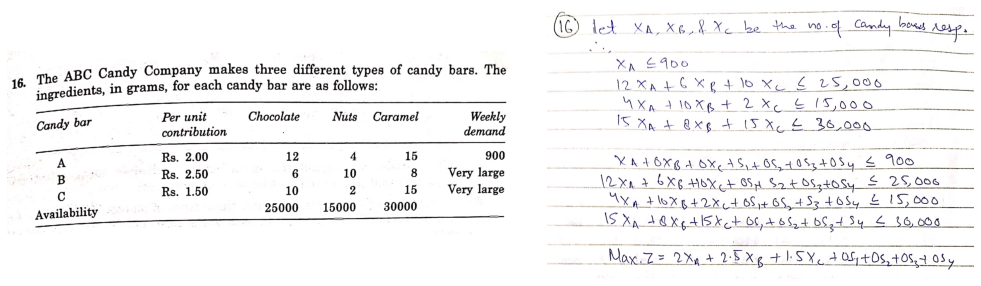

In [38]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
que = mpimg.imread(r'images\que16.png')
eqn = mpimg.imread(r'images\eqn16.png')
ax[0].imshow(que)
ax[1].imshow(eqn)
_ = ax[0].axis(False)
_ = ax[1].axis(False)
fig.subplots_adjust(wspace=0, hspace=0)

In [3]:
#### QUESTION 16

#coefficients in z
c  = np.array([2,2.5,1.5,0,0,0,0])

#coefficients in constraints
mat = np.array([[1,0,0,1,0,0,0, 900],
                [12,6,10,0,1,0,0, 25000],
                [4,10,2,0,0,1,0, 15000],
                [15,8,15,0,0,0,1, 30000]])



### Initialize the table with coefficients

In [12]:
def prepare_input_table(coefficients, mat):
    '''
    - Takes in coefficients of the variable for the equation Z,
    - where Z is the objective function
    - The order of variables is like:
        x1, x2, x3,... xi, s1, s2, s3,... sj, -M*A1, -M*A2,..., -M*An
    '''
    
    
    c = coefficients
    M = 10e10
    #Auto-name variables

    v = []                   #this list will conatin respective names for the variables 
    i = 1
    for coeff in c:
        if (coeff != 0) & (coeff!= -M):
            name = 'x' + str(i)
            v.append(name)
            i += 1

        elif coeff == 0:
            if ('s' not in v[-1]):
                i = 1

            name = 's' + str(i)
            v.append(name)
            i += 1

        elif coeff == -M:
            if ('A' not in v[-1]):
                i = 1

            name = 'A' + str(i)
            v.append(name)
            i += 1



    a = pd.DataFrame(mat[:,:-1], columns = v)
    b = pd.Series(mat[:,-1], name = 'b')
    m = len(b)
    z = {var:coeff for (var, coeff) in zip(v,c)}
    z= pd.DataFrame(z, index= [0])
    
    print('Objective Function, z:')
    display(z)
    print('\n')
    print('Initialized table:')
    cmat = pd.concat([a, b], axis = 1)
    display(cmat)
    return cmat, v, a, b, m, z

### Create Function for performing the simplex algorithm

In [40]:
def perform_simplex(coefficients, mat):
    
    M = 10e10                 #Set value to M to be comparitively large number (it is infinity in theory)
    xn = len(c) - list(c).count(0)- list(c).count(-M) #xn is number of x's in the objective function.
    n = len(c)
    
    #Initialize the table
    cmat, v, a, b, m, z = prepare_input_table(coefficients, mat)
    
    #Select basic variables and create Basis column
    basis = []
    sa_var= cmat[v[xn:]]
    for i in sa_var.index:
        val = (sa_var.iloc[i,:])[sa_var.iloc[i,:] > 0]
        basis.append(val.index[0])

    #Create table
    table0 = pd.DataFrame({'Basis': basis, 'cb': z[basis].values[0]})

    r = pd.Series(np.zeros(m), name ='r')
    table = pd.concat([table0, a, b, r], axis=1)

    #Optimality test function
    def optest(table, c):
        zj = np.matmul(table.cb,table.iloc[:, 2:-1])
        Cj  = c - zj[:-1]
        Cj.name = 'Cj'
        zj.name = 'zj'
        return Cj, zj

    tables = []
    
    #ITERATIONS

    iter = 0
    Cj = np.ones(len(c))
    while Cj[Cj>0].any() > 0:

        Cj, zj = optest(table, c)
        ivar = Cj.idxmax()

        table['r'] = table.b/table[ivar]

        print('-'*100)
        print('iter = ', iter)
        print(z)
        print('-'*100)
        tablei = pd.concat([table,pd.DataFrame(zj).T,pd.DataFrame(Cj).T])
        print(tablei)

        if Cj[Cj>0].size != 0:
            print('incoming variable = ', ivar)


        if table[table['r'] > 0].r.any() > 0 and Cj[Cj>0].any() > 0:

            ovar_idx = table[table.r > 0].r.idxmin()

            key = table.loc[ovar_idx, ivar]
            print('outgoing variable = ', table.loc[ovar_idx, 'Basis'])

            #Divide key row by key element

            table.iloc[ovar_idx,2:-1] /= key

            keyrow = table.iloc[ovar_idx,2:-1]
            table.iloc[ovar_idx, 2:-1] = keyrow

            for i in range(m):
                if i == ovar_idx: pass
                else:
                    table.iloc[i,2:-1] -= table.loc[i,ivar]*keyrow

            #Make replacement of ivar and ovar

            table.loc[ovar_idx, 'Basis'] = ivar    
            table.loc[ovar_idx, 'cb'] = c[v.index(ivar)]


        tables.append(tablei)
        iter += 1
        print("\n")
    print('Optimum value of z is ', tables[-1].loc['zj', 'b'])
    
    return tables

### Execute the function

In [41]:
tables = perform_simplex(c, mat)

Objective Function, z:


,x1,x2,x3,s1,s2,s3,s4
0,2.0,2.5,1.5,0.0,0.0,0.0,0.0




Initialized table:


,x1,x2,x3,s1,s2,s3,s4,b
0,1,0,0,1,0,0,0,900
1,12,6,10,0,1,0,0,25000
2,4,10,2,0,0,1,0,15000
3,15,8,15,0,0,0,1,30000


----------------------------------------------------------------------------------------------------
iter =  0
    x1   x2   x3   s1   s2   s3   s4
0  2.0  2.5  1.5  0.0  0.0  0.0  0.0
----------------------------------------------------------------------------------------------------
   Basis   cb    x1    x2    x3   s1   s2   s3   s4        b         r
0     s1  0.0   1.0   0.0   0.0  1.0  0.0  0.0  0.0    900.0       inf
1     s2  0.0  12.0   6.0  10.0  0.0  1.0  0.0  0.0  25000.0  4166.667
2     s3  0.0   4.0  10.0   2.0  0.0  0.0  1.0  0.0  15000.0  1500.000
3     s4  0.0  15.0   8.0  15.0  0.0  0.0  0.0  1.0  30000.0  3750.000
zj   NaN  NaN   0.0   0.0   0.0  0.0  0.0  0.0  0.0      0.0       NaN
Cj   NaN  NaN   2.0   2.5   1.5  0.0  0.0  0.0  0.0      NaN       NaN
incoming variable =  x2
outgoing variable =  s3


----------------------------------------------------------------------------------------------------
iter =  1
    x1   x2   x3   s1   s2   s3   s4
0  2.0  2.5  1.5  0

### Neat view of tables

In [15]:
for t in tables: display(t)

,Basis,cb,x1,x2,x3,s1,s2,s3,s4,b,r
0,s1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,900.0,inf
1,s2,0.0,12.0,6.0,10.0,0.0,1.0,0.0,0.0,25000.0,4166.667
2,s3,0.0,4.0,10.0,2.0,0.0,0.0,1.0,0.0,15000.0,1500.000
3,s4,0.0,15.0,8.0,15.0,0.0,0.0,0.0,1.0,30000.0,3750.000
zj,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
Cj,NaN,NaN,2.0,2.5,1.5,0.0,0.0,0.0,0.0,NaN,NaN


,Basis,cb,x1,x2,x3,s1,s2,s3,s4,b,r
0,s1,0.0,1.0,0.0,0.0,1.0,0.0,0.00,0.0,900.0,900.000
1,s2,0.0,9.6,0.0,8.8,0.0,1.0,-0.60,0.0,16000.0,1666.667
2,x2,2.5,0.4,1.0,0.2,0.0,0.0,0.10,0.0,1500.0,3750.000
3,s4,0.0,11.8,0.0,13.4,0.0,0.0,-0.80,1.0,18000.0,1525.424
zj,NaN,NaN,1.0,2.5,0.5,0.0,0.0,0.25,0.0,3750.0,NaN
Cj,NaN,NaN,1.0,0.0,1.0,0.0,0.0,-0.25,0.0,NaN,NaN


,Basis,cb,x1,x2,x3,s1,s2,s3,s4,b,r
0,x1,2.0,1.0,0.0,0.0,1.0,0.0,0.00,0.0,900.0,inf
1,s2,0.0,0.0,0.0,8.8,-9.6,1.0,-0.60,0.0,7360.0,836.364
2,x2,2.5,0.0,1.0,0.2,-0.4,0.0,0.10,0.0,1140.0,5700.000
3,s4,0.0,0.0,0.0,13.4,-11.8,0.0,-0.80,1.0,7380.0,550.746
zj,NaN,NaN,2.0,2.5,0.5,1.0,0.0,0.25,0.0,4650.0,NaN
Cj,NaN,NaN,0.0,0.0,1.0,-1.0,0.0,-0.25,0.0,NaN,NaN


,Basis,cb,x1,x2,x3,s1,s2,s3,s4,b,r
0,x1,2.0,1.0,0.0,0.0,1.000,0.0,0.000,0.000,900.000,900.0
1,s2,0.0,0.0,0.0,0.0,-1.851,1.0,-0.075,-0.657,2513.433,inf
2,x2,2.5,0.0,1.0,0.0,-0.224,0.0,0.112,-0.015,1029.851,inf
3,x3,1.5,0.0,0.0,1.0,-0.881,0.0,-0.060,0.075,550.746,inf
zj,NaN,NaN,2.0,2.5,1.5,0.119,0.0,0.190,0.075,5200.746,NaN
Cj,NaN,NaN,0.0,0.0,0.0,-0.119,0.0,-0.190,-0.075,NaN,NaN
